In [27]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.applications import DenseNet201
from tensorflow.keras.applications import EfficientNetB3
from keras import layers, models
from datetime import datetime
from tqdm import tqdm
import shutil
import os
import sys
import pandas as pd
import my_evaluate
import cv2
import matplotlib.pyplot as plt

In [28]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './data/aug_training_data.txt'
IMAGE_DIR = './data/aug_JPEG/'
MOS_DATA_PATH = './data/mos_training_data.txt'
MOS_IMAGE_DIR = './data/mos_JPEG/'
COM_DATA_PATH = './data/combined_training_data.txt'
COM_IMAGE_DIR = './data/combined_JPEG/'
CKP_DIR = './ckpts/YOLO'
# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 20
NOOBJECT_SCALE = 10
CLASS_SCALE = 15
COORD_SCALE = 70

# training params
LEARNING_RATE = 5e-5
EPOCHS = 40
MOS_EPOCHS = 30

In [30]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5, 
                                            MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
                
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = (image/255) * 2 - 1

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                      np.array(self.record_list), 
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)
        dataset = dataset.map(self._data_preprocess, 
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE , drop_remainder=True)
        dataset = dataset.prefetch(buffer_size = 200)

        return dataset

In [ ]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=keras.initializers.TruncatedNormal())(inputs)
    x = layers.LeakyReLU(0.1)(x)
    return x

def modified_yolo_with_densenet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)):
    # Load DenseNet without top layers and set it as non-trainable
    densenet = DenseNet201(include_top = False, input_shape = input_shape)
    densenet.trainable = False  # Freeze DenseNet layers for feature extraction
    
    # Get DenseNet output as feature extractor
    x = densenet.output
    x = conv_leaky_relu(x, 512, 3, 1)
    x = conv_leaky_relu(x, 1024, 3, 1)
    
    # Pass DenseNet features to a reduced YOLO model
    x = conv_leaky_relu(x, 64, 3, 1)  # Use a smaller stride to preserve dimensions
    x = conv_leaky_relu(x, 128, 3, 1)
    x = layers.MaxPool2D()(x)

    x = conv_leaky_relu(x, 256, 3, 1)
    x = conv_leaky_relu(x, 512, 3, 1)
    x = conv_leaky_relu(x, 1024, 3, 1)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(2048, kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.01))(x)
    x = layers.LeakyReLU(0.1)(x)
    outputs = layers.Dense(1470, kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.01))(x)
    
    # Define the complete model
    model = models.Model(inputs=densenet.input, outputs=outputs, name="YOLO")
    return model

def modified_yolo_with_efficientnet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)):
    # Load EfficientNet without top layers and set it as non-trainable
    efficientnet = EfficientNetB3(include_top=False, input_shape=input_shape)
    efficientnet.trainable = False  # Freeze EfficientNet layers for feature extraction
    
    # Get EfficientNet output as feature extractor
    x = efficientnet.output  # Output shape: (14, 14, 1536) for EfficientNetB3
    
    # Additional convolution to adjust the feature dimensions
    x = conv_leaky_relu(x, 512, 3, 1)
    x = conv_leaky_relu(x, 1024, 3, 1)
    x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="same")(x)
    
    # Pass EfficientNet features to a reduced YOLO model
    x = conv_leaky_relu(x, 64, 3, 1)  # Use a smaller stride to preserve dimensions
    x = conv_leaky_relu(x, 128, 3, 1)
    x = layers.MaxPool2D()(x)

    x = conv_leaky_relu(x, 256, 3, 1)
    x = conv_leaky_relu(x, 512, 3, 1)
    x = conv_leaky_relu(x, 1024, 3, 1)
    
    # Pooling and fully connected layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(2048, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
    x = layers.LeakyReLU(0.1)(x)
    outputs = layers.Dense(1470, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
    
    # Define the complete model
    model = models.Model(inputs=efficientnet.input, outputs=outputs, name="YOLO_EfficientNet")
    return model


In [32]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, 
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [33]:
def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.
    
    #you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss/BATCH_SIZE

In [34]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    #Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    #turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)
    
    #calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    #Step B. calculate the coordination of object center and the corresponding mask
    #turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    #calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                             tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    #make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    #Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])
    #cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    #calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    #replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

In [35]:
# Instantiate the model
YOLO = modified_yolo_with_densenet()
YOLO.summary()

Model: "YOLO"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 454, 454, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 224, 224, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                              

In [36]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))

In [37]:
def combine_datasets(original_data_path, original_image_dir, additional_data_path, additional_image_dir,
                     combined_data_path, combined_image_dir):
    # 創建合併後的文件夾
    if not os.path.exists(combined_image_dir):
        os.makedirs(combined_image_dir)
    
    # 合併註釋文件
    with open(combined_data_path, 'w') as combined_file:
        with open(original_data_path, 'r') as original_file:
            combined_file.writelines(original_file.readlines())
        with open(additional_data_path, 'r') as additional_file:
            combined_file.writelines(additional_file.readlines())
    
    # 複製圖像文件到新的文件夾
    for image_file in os.listdir(original_image_dir):
        shutil.copy(os.path.join(original_image_dir, image_file), combined_image_dir)
    for image_file in os.listdir(additional_image_dir):
        shutil.copy(os.path.join(additional_image_dir, image_file), combined_image_dir)

    print("Datasets combined successfully.")

In [38]:
# ckpt.restore('./ckpts/YOLO/yolo-5')
ckpt = tf.train.Checkpoint(epoch = tf.Variable(0), net = YOLO)
manager = tf.train.CheckpointManager(ckpt, CKP_DIR, max_to_keep = 20, checkpoint_name='yolo')

In [39]:
dataset = DatasetGenerator().generate()
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

In [40]:
combine_datasets(
    original_data_path=DATA_PATH,
    original_image_dir=IMAGE_DIR,
    additional_data_path=MOS_DATA_PATH,
    additional_image_dir=MOS_IMAGE_DIR,
    combined_data_path=COM_DATA_PATH,
    combined_image_dir=COM_IMAGE_DIR)

Datasets combined successfully.


In [41]:
print(f'{datetime.now()}, start training.')
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    if i == MOS_EPOCHS + 1:   
        DATA_PATH = COM_DATA_PATH
        IMAGE_DIR = COM_IMAGE_DIR
        dataset = DatasetGenerator().generate()
        
    for idx, (image, labels, objects_num) in enumerate(tqdm(dataset)):
        train_step(image, labels, objects_num)

    print(f'{datetime.now()}, Epoch {i+1}: loss {train_loss_metric.result():.2f}')

    save_path = manager.save()
    print(f'Saved checkpoint for epoch {int(ckpt.epoch)}: {save_path}')
    

2024-11-14 21:45:06.862286, start training.


  0%|          | 0/1422 [00:00<?, ?it/s]

100%|██████████| 1422/1422 [05:53<00:00,  4.02it/s]


2024-11-14 21:51:00.346901, Epoch 1: loss 325.61
Saved checkpoint for epoch 1: ./ckpts/YOLO\yolo-1


 15%|█▌        | 216/1422 [00:58<05:28,  3.67it/s]


KeyboardInterrupt: 

## predict

In [ ]:
ckpt = tf.train.Checkpoint(epoch = tf.Variable(0), net = YOLO)
ckpt.restore('./ckpts/YOLO/yolo-40')

In [ ]:
test_img_files = open('./data/pascal_voc_testing_data.txt')
test_img_dir = './data/VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [ ]:
@tf.function
def prediction_step(img):
    return YOLO(img, training=False)

In [ ]:
def process_outputs(outputs , threshold = 0.5):
    '''
    Process YOLO outputs into bou
    '''
    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, CELL_SIZE, CELL_SIZE, NUM_CLASSES))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL))
    boxes = np.reshape(outputs[:, conf_end:], (-1, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL * 4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, :NUM_CLASSES]
    C = predicts[0, :, :, NUM_CLASSES:NUM_CLASSES+BOXES_PER_CELL]
    coordinate = predicts[0, :, :, NUM_CLASSES+BOXES_PER_CELL:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, NUM_CLASSES))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    # P's shape [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, NUM_CLASSES]

    xmin, ymin, xmax, ymax, class_num, conf = [], [], [], [], [], []

    max_conf_idx = np.unravel_index(np.argmax(P), P.shape)
    if(P[max_conf_idx] > 0.3) :
        threshold = P[max_conf_idx] / 2
        
    result = []
    for i in range(np.prod(P.shape)):
        idx = np.unravel_index(i, P.shape)
        if (P[idx] > threshold):
            class_num = (idx[3])
            conf = (P[idx])
            coordinate = np.reshape(coordinate, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4))
            xcenter, ycenter, w, h = coordinate[idx[0], idx[1], idx[2], :]

            xcenter = (idx[1] + xcenter) * (IMAGE_SIZE / float(CELL_SIZE))
            ycenter = (idx[0] + ycenter) * (IMAGE_SIZE / float(CELL_SIZE))

            w = w * IMAGE_SIZE
            h = h * IMAGE_SIZE

            xmin = (xcenter - w / 2.0)
            ymin = (ycenter - h / 2.0)

            xmax = xmin + w
            ymax = ymin + h
            result.append((xmin, ymin, xmax, ymax, class_num, conf))
    return result


In [ ]:
def box_iou_batch(boxes_a, boxes_b):
    def box_area(box):
        return (box[2] - box[0]) * (box[3] - box[1])

    area_a = box_area(boxes_a.T)
    area_b = box_area(boxes_b.T)

    top_left = np.maximum(boxes_a[:, None, :2], boxes_b[:, :2])
    bottom_right = np.minimum(boxes_a[:, None, 2:], boxes_b[:, 2:])

    area_inter = np.prod(
    	np.clip(bottom_right - top_left, a_min=0, a_max=None), 2)
        
    return area_inter / (area_a[:, None] + area_b - area_inter)

In [ ]:
def non_max_suppression(predictions, iou_threshold = 0.4):
    rows, columns = predictions.shape

    sort_index = np.flip(predictions[:, 5].argsort())
    predictions = predictions[sort_index]

    boxes = predictions[:, :4]
    categories = predictions[:, 4]
    ious = box_iou_batch(boxes, boxes)
    ious = ious - np.eye(rows)

    keep = np.ones(rows, dtype=bool)

    for index, (iou, category) in enumerate(zip(ious, categories)):
        if not keep[index]:
            continue

        condition = (iou > iou_threshold) & (categories == category)
        keep = keep & ~condition

    return keep[sort_index.argsort()]

In [ ]:
output_file = open('./data/test_prediction.txt', 'w')  
for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        # xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        all_boxes = process_outputs(prediction_step(test_img[i:i+1]) , 0.01)
        all_boxes = np.array(all_boxes)
        if len(all_boxes) == 0:
            continue
        keep = non_max_suppression(all_boxes , 0.4)
        nms_boxes = all_boxes[keep]
        for xmin, ymin, xmax, ymax, class_num, conf in nms_boxes:
            xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1] / IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)
            #img filename, xmin, ymin, xmax, ymax, class, confidence
            output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

output_file.close()
my_evaluate.evaluate('./data/test_prediction.txt', './output_file.csv')
cap = pd.read_csv('./output_file.csv')['packedCAP']
print('score: {:f}'.format(sum((1. - cap) ** 2) / len(cap)))

End Evalutation
score: 0.447460


# Make Prediction and Output to txt file

In [ ]:
iou_thresholds = np.arange(0.2, 0.7, 0.1)
thresholds = np.arange(0.02, 0.06, 0.01)

In [ ]:
sys.path.insert(0, './evaluate')
for threshold in thresholds:
    for iou_threshold in iou_thresholds:
        output_file = open('./data/test_prediction.txt', 'w')
        print(f"threshold = {threshold} , iou_thresholds = {iou_threshold}")
        for img_name, test_img, img_h, img_w in test_dataset:
                    batch_num = img_name.shape[0]
                    for i in range(batch_num):
                        # xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
                        all_boxes = process_outputs(prediction_step(test_img[i:i+1]) , threshold)
                        all_boxes = np.array(all_boxes)
                        if len(all_boxes) == 0:
                            continue
                        keep = non_max_suppression(all_boxes , iou_threshold)
                        nms_boxes = all_boxes[keep]
                        for xmin, ymin, xmax, ymax, class_num, conf in nms_boxes:
                            xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1] / IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)
                            #img filename, xmin, ymin, xmax, ymax, class, confidence
                            output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

        output_file.close()
        my_evaluate.evaluate('./data/test_prediction.txt', './output_file.csv')
        cap = pd.read_csv('./output_file.csv')['packedCAP']
        print('score: {:f}'.format(sum((1. - cap) ** 2) / len(cap)))
        # threshold 0.01 , iou_thresholds = 0.4

threshold = 0.02 , iou_thresholds = 0.2
End Evalutation
score: 0.469837
threshold = 0.02 , iou_thresholds = 0.30000000000000004
End Evalutation
score: 0.465353
threshold = 0.02 , iou_thresholds = 0.4000000000000001


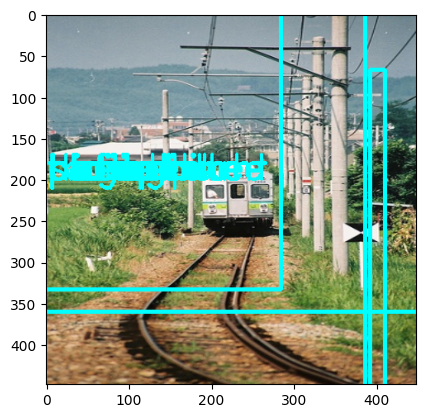

In [ ]:
np_img = cv2.imread('./data/VOCdevkit_test/VOC2007/JPEGImages/000002.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

all_boxes = process_outputs(prediction_step(np_img) , 0.01)
all_boxes = np.array(all_boxes)
keep = non_max_suppression(all_boxes , 0.4)
nms_boxes = all_boxes[keep]
for xmin, ymin, xmax, ymax, class_num, conf in nms_boxes:
    class_name = classes_name[int(class_num)]
    cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
    cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)

plt.imshow(resized_img)
plt.show()